In [1]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP, ABPR, GPR
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('New-ML_implicit')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
base_conf = {'embedding_dim':1, 'lr':0, 'weight_decay':0}
trials = 0 # Eval mode

MovieLens data prepared: 6034 users, 3125 items.
461948 train, 58117 validation and 54311 test interactions.


# BPR

In [3]:
name = 'BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8925263758722911, 'Rating_rec': {'MAP': array([0.32515744, 0.40669539, 0.43368136, 0.4384046 , 0.44130621,
       0.43834144, 0.43547059, 0.43068286, 0.4261577 , 0.4222308 ]), 'Recall': array([0.02955659, 0.05317524, 0.07441884, 0.09175574, 0.10757974,
       0.12169176, 0.13547589, 0.14797676, 0.16061648, 0.17171381])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.47235,2022-05-11 17:58:13.018476,2022-05-11 18:06:10.325277,0 days 00:07:57.306801,6513,115,0.000321,7.545518e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# Heuristics

In [3]:
results_isup = test(ItemHeuristic(base_MF=model, uncertainty=-data.item_support), data, max_k=10, name='NEG-ITEM-SUPPORT')
clear_output(wait=True)
results_isup

{'FCP': 0.8925263758722911,
 'Concordant uncertainty': -633.6892973552832,
 'Discordant uncertainty': -300.40911427102964,
 'corr_usup': 0.0006556494295395719,
 'corr_udiv': -0.00114766914804422,
 'corr_isup': -0.9999999999999998,
 'Rating_rec': {'MAP': array([0.32515744, 0.40669539, 0.43368136, 0.4384046 , 0.44130621,
         0.43834144, 0.43547059, 0.43068286, 0.4261577 , 0.4222308 ]),
  'Recall': array([0.02955659, 0.05317524, 0.07441884, 0.09175574, 0.10757974,
         0.12169176, 0.13547589, 0.14797676, 0.16061648, 0.17171381]),
  'Unc_MAP_corr': 0.0888551192261807,
  'URI': 0.12914419969037894},
 'Cuts': {'Values': array([ -15.,  -38.,  -98., -247.]),
  'Coverage': array([1., 1., 1., 1., 1.]),
  'Relevance': array([4.21988391, 4.21987779, 4.21968286, 4.2166764 , 4.19345286]),
  'MAP': array([0.4222308 , 0.4222308 , 0.42230512, 0.42314388, 0.4243931 ]),
  'Map*': array([0.4222308 , 0.4222308 , 0.42230512, 0.42314388, 0.4243931 ])}}

# Ensemble / Resample

In [4]:
best_params = study.best_params
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble', name=f'{i}')
models = [init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])]
for file in os.listdir('checkpoints/ensemble'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
results_ensemble = test(ensemble, data, name='ENSEMBLE', max_k=10)
clear_output(wait=True)

if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model('bprMF', **best_params))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results_resample = test(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_ensemble, results_resample

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/resample'

# Linear-GPR

In [6]:
name = 'Linear-GPR'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8294820570418515, 'Concordant uncertainty': 1.770392, 'Discordant uncertainty': 1.7942674, 'corr_usup': -0.6901489176893746, 'corr_udiv': -0.1588225211739242, 'corr_isup': -0.29050241346786787, 'Rating_rec': {'MAP': array([0.17699702, 0.2310242 , 0.24925423, 0.2568869 , 0.26066273,
       0.26162238, 0.26290144, 0.26226975, 0.2605143 , 0.25955561]), 'Recall': array([0.0122898 , 0.02330801, 0.03182145, 0.03860308, 0.04558899,
       0.05254773, 0.06093182, 0.0675761 , 0.07459686, 0.08112629]), 'Unc_MAP_corr': -0.5017217368363178, 'URI': -0.009739278633312679}, 'Cuts': {'Values': array([1.83985186, 1.82551169, 1.81030979, 1.79146612]), 'Coverage': array([1.        , 1.        , 1.        , 1.        , 0.99960225]), 'Relevance': array([2.06488904, 2.064889  , 2.06488801, 2.06487998, 2.06425775]), 'MAP': array([0.25955561, 0.25955561, 0.25955561, 0.25951878, 0.25972594]), 'Map*': array([0.25955561, 0.25955561, 0.25955561, 0.25951878, 0.26015709])}, 'Uncertain_rec': {'MAP': array(

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
1,1,0.292604,2022-05-11 21:47:23.350902,2022-05-11 21:48:14.517377,0 days 00:00:51.166475,3227,200,0.000209,1.928842e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
0,0,0.286594,2022-05-11 18:06:16.113003,2022-05-11 18:07:29.375633,0 days 00:01:13.262630,3966,79,0.000114,8.186227e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# FunkSVD-GPR

In [7]:
name = 'FunkSVD-GPR'
def init_model(**kwargs):
    return TwoWayMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8605439045497228, 'Concordant uncertainty': 0.0011982161, 'Discordant uncertainty': 0.0014432693, 'corr_usup': -0.6245886135116678, 'corr_udiv': -0.3779464766725912, 'corr_isup': -0.5022716355994786, 'Rating_rec': {'MAP': array([0.28737156, 0.35846868, 0.38371451, 0.39171546, 0.39505626,
       0.39348387, 0.3889477 , 0.38476523, 0.38141279, 0.3769829 ]), 'Recall': array([0.02336536, 0.04410404, 0.06057251, 0.07530104, 0.08869422,
       0.1014312 , 0.11408482, 0.12458156, 0.13438348, 0.14306674]), 'Unc_MAP_corr': -0.36752786981880947, 'URI': 0.060983492045399046}, 'Cuts': {'Values': array([0.01483045, 0.00556709, 0.00203434, 0.00053451]), 'Coverage': array([1.        , 0.99466357, 0.96373881, 0.86963871, 0.6748757 ]), 'Relevance': array([0.60456222, 0.59845725, 0.5683102 , 0.49746493, 0.36835909]), 'MAP': array([0.3769829 , 0.3747647 , 0.36178056, 0.33506924, 0.27610752]), 'Map*': array([0.3769829 , 0.37701404, 0.3772448 , 0.38893557, 0.4149779 ])}, 'Uncertain_rec': {'MAP': 

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.427484,2022-05-11 21:48:24.616486,2022-05-11 21:52:39.922073,0 days 00:04:15.305587,3039,161,0.000783,4.934289e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# GMF-GPR

In [8]:
name = 'GMF-GPR'
def init_model(**kwargs):
    return bprGMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8942755611202151, 'Concordant uncertainty': 0.14058846, 'Discordant uncertainty': 0.2841256, 'corr_usup': -0.18388068442332828, 'corr_udiv': -0.17616409203002525, 'corr_isup': -0.3490378418527792, 'Rating_rec': {'MAP': array([0.34040438, 0.40404375, 0.42550547, 0.43312894, 0.43273902,
       0.43026194, 0.4249326 , 0.41966382, 0.41401138, 0.40874924]), 'Recall': array([0.02838384, 0.04904517, 0.06668264, 0.08322432, 0.09854226,
       0.11320519, 0.12663673, 0.13910481, 0.1504366 , 0.16234611]), 'Unc_MAP_corr': -0.1645081228801114, 'URI': 0.09510549537106239}, 'Cuts': {'Values': array([1.19452837, 0.71800791, 0.42095715, 0.19744309]), 'Coverage': array([1., 1., 1., 1., 1.]), 'Relevance': array([7.00788044, 7.00324625, 6.99368356, 6.96924847, 6.88719661]), 'MAP': array([0.40874924, 0.40896521, 0.40860992, 0.40766571, 0.40467735]), 'Map*': array([0.40874924, 0.40896521, 0.40860992, 0.40766571, 0.40467735])}, 'Uncertain_rec': {'MAP': array([0.33410673, 0.40139211, 0.42315766, 0.

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.452712,2022-05-11 21:52:53.196308,2022-05-11 21:59:50.474457,0 days 00:06:57.278149,5462,84,0.000371,5.973851e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# MLP-GPR

In [9]:
name = 'MLP-GPR'
def init_model(**kwargs):
    return bprMLP(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8200732816556499, 'Concordant uncertainty': 0.008873075, 'Discordant uncertainty': 0.0894368, 'corr_usup': -0.387770630145578, 'corr_udiv': -0.2438425651762868, 'corr_isup': -0.7597978718290411, 'Rating_rec': {'MAP': array([0.11501492, 0.14849188, 0.16304828, 0.17631569, 0.181787  ,
       0.18560555, 0.18833866, 0.189685  , 0.18975186, 0.19012783]), 'Recall': array([0.00907445, 0.01507984, 0.01983131, 0.02706818, 0.03274469,
       0.03827596, 0.0433913 , 0.04887954, 0.05400347, 0.05855946]), 'Unc_MAP_corr': -0.29768021503813036, 'URI': 0.08135691962006905}, 'Cuts': {'Values': array([4.99050105e-01, 3.18694495e-02, 2.02130969e-03, 7.43117722e-05]), 'Coverage': array([1.        , 0.99970169, 0.99883991, 0.99499503, 0.95372887]), 'Relevance': array([14.91895962, 14.91927437, 14.91977327, 14.90760016, 14.71780595]), 'MAP': array([0.19012783, 0.19012783, 0.19012783, 0.19009468, 0.18770166]), 'Map*': array([0.19012783, 0.19019087, 0.19044345, 0.19123563, 0.19494718])}, 'Uncertain

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.177552,2022-05-11 22:00:02.521869,2022-05-11 22:01:07.677764,0 days 00:01:05.155895,3130,55,0.000487,8.319056e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# Results

                       FCP  Concordant uncertainty  Discordant uncertainty  \
BPR               0.892526                     NaN                     NaN   
NEG-ITEM-SUPPORT  0.892526             -633.689297             -300.409114   
Linear-GPR        0.829482                1.770392                1.794267   
FunkSVD-GPR       0.860544                0.001198                0.001443   
GMF-GPR           0.894276                0.140588                0.284126   
MLP-GPR           0.820073                0.008873                0.089437   

                      Ratio  
BPR                     NaN  
NEG-ITEM-SUPPORT   0.474064  
Linear-GPR         1.013486  
FunkSVD-GPR        1.204515  
GMF-GPR            2.020974  
MLP-GPR           10.079572  
                       URI  Unc_MAP_corr
NEG-ITEM-SUPPORT  0.129144      0.088855
Linear-GPR       -0.009739     -0.501722
FunkSVD-GPR       0.060983     -0.367528
GMF-GPR           0.095105     -0.164508
MLP-GPR           0.081357     -0.2976

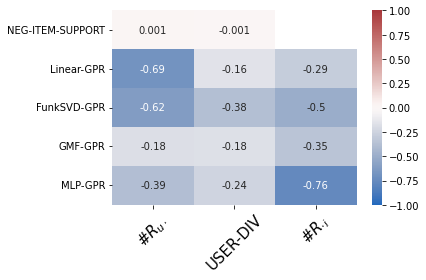

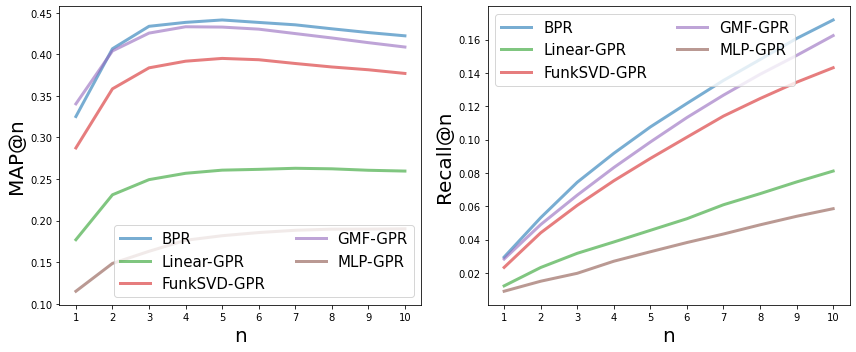

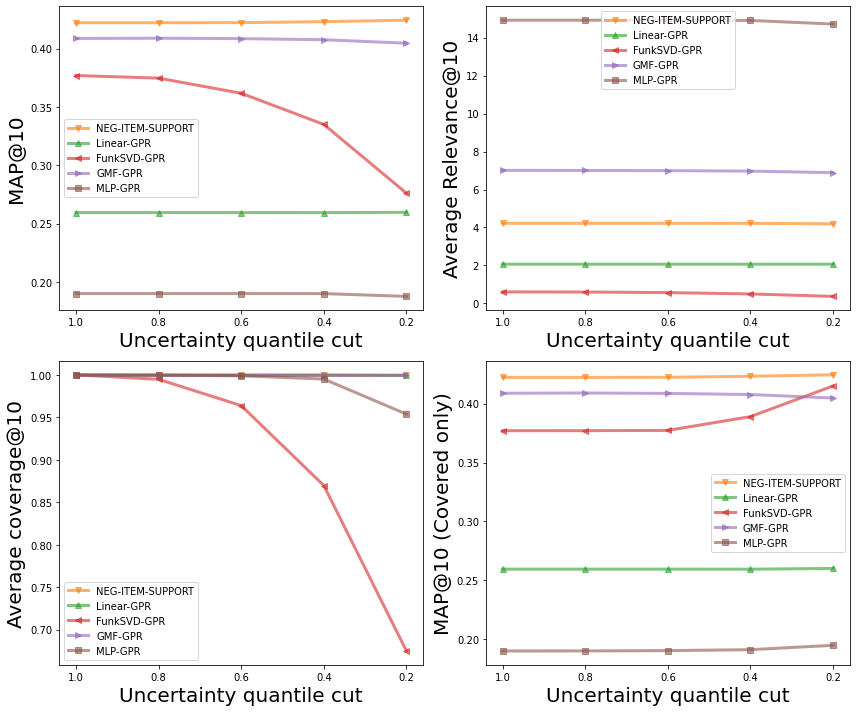

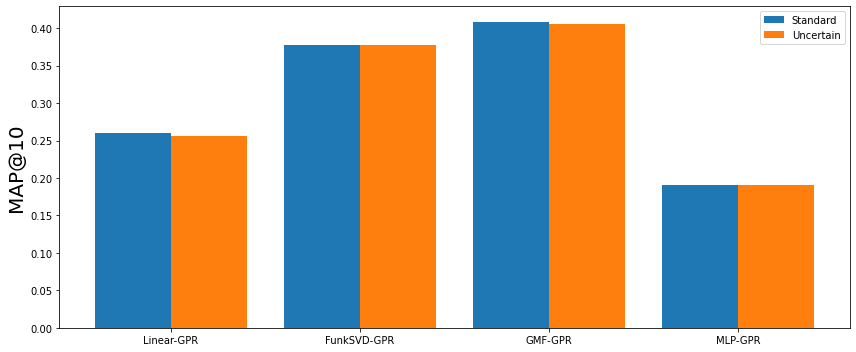

In [12]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['BPR', 'NEG-ITEM-SUPPORT', 'Linear-GPR', 'FunkSVD-GPR', 'GMF-GPR', 'MLP-GPR']
results = dict((key, results[key]) for key in order)
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Rating prediction evaluation
ratings = pd.DataFrame([results[key] for key in results], index=results.keys())[['FCP', 'Concordant uncertainty', 'Discordant uncertainty']]
ratings['Ratio'] = ratings['Discordant uncertainty'] / ratings['Concordant uncertainty']
print(ratings)

# URI and UAC
keys = [key for key in results if key != 'BPR']
a = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI', 'Unc_MAP_corr']]
print(a)

# Correlation plot
corr = np.empty((len(results)-1, 3))
keys = [key for key in results if key != 'BPR']
for idx, key in enumerate(keys):
    corr[idx, 0] = results[key]['corr_usup']
    corr[idx, 1] = results[key]['corr_udiv']
    corr[idx, 2] = results[key]['corr_isup']
corr = pd.DataFrame(corr, index=keys, columns=[r'#$R_{u\cdot}$', 'USER-DIV', r'#$R_{\cdot i}$'])
corr.loc['NEG-ITEM-SUPPORT', r'#$R_{\cdot i}$'] = np.nan
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

# Top-K accuracy metrics
keys = [key for key in results if key != 'NEG-ITEM-SUPPORT' and key != 'ENSEMBLE' and key != 'RESAMPLE']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

# Cuts
keys = [key for key in results if key != 'BPR']
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
for key in keys:
    ax[0, 0].plot(results[key]['Cuts']['MAP'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[0, 1].plot(results[key]['Cuts']['Relevance'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 0].plot(results[key]['Cuts']['Coverage'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 1].plot(results[key]['Cuts']['Map*'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0, 0].set_xticks(range(5))
ax[0, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 0].set_ylabel('MAP@10', fontsize=20)
ax[0, 0].legend()
ax[0, 1].set_xticks(range(5))
ax[0, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 1].set_ylabel('Average Relevance@10', fontsize=20)
ax[0, 1].legend()
ax[1, 1].set_xticks(range(5))
ax[1, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 1].set_ylabel('MAP@10 (Covered only)', fontsize=20)
ax[1, 1].legend()
ax[1, 0].set_xticks(range(5))
ax[1, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 0].set_ylabel('Average coverage@10', fontsize=20)
ax[1, 0].legend()
f.tight_layout()
f.savefig('plots/cuts.pdf')

# Rating prediction evaluation
keys = [key for key in keys if key != 'RESAMPLE' and key != 'NEG-ITEM-SUPPORT']
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots(figsize=(12, 5))
ax.bar(np.arange(len(keys))-0.2, precision['Standard'], 0.4, label='Standard')
ax.bar(np.arange(len(keys))+0.2, precision['Uncertain'], 0.4, label='Uncertain')
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('plots/unc_rank.pdf')

In [ ]:
print('Average item popularity on training: {}'.format(data.item_support[data.train[:, 1]].mean()))
print('Average item popularity on validation: {}'.format(data.item_support[data.val[:, 1]].mean()))
print('Average item popularity on test: {}'.format(data.item_support[data.test[:, 1]].mean()))

- [X] Check if all models in explicit case are outputting uncertainty properly. 

- [X] BeMF should not borrow the uncertainty metric from the rating case into the recommendation case / BeMF could do simply 1 - P(r > 4) as uncertainty. This would make uncertainty inversely proportional to relevance, but does the absolute values of the numbers still add something?

- [X] Also think about the absolute uncertainty numbers for the other models. Vanilla RRI might be the answer.

- [X] Check giovanni's paper experiment description (especially the early stopping part). There, they use MAP for early stopping as well, which removes the need of negative samples but increase the computational cost. They do validation check every 5 epochs. Their batch size also varies and is sometimes really small, which means that 5 epochs may consist of lots and lots of updates.

## RRI formulation

- Original: $$ \frac{\rho_{ui} - \bar{\rho}}{\sigma_\rho} $$
- Ours: $$ \frac{\rho_{ui} - \bar{\rho_u}}{\sigma_{\rho_u}} $$

We aknowledged that the original form has the problem of penalizing correct recommendations every time that their uncertainty is higher than the average uncertainty. For this reason we changed to the user based form, in which the uncertainties are compared to the user average uncertainty, and therefore a penalty to the RRI value occurs only if the uncertainty of the correct recommendation is higher than the average uncertainty for the user.

Nevertheless, our formulation does not analyze the recommendation in a cross-user aspect. Ideally, if uncertainty is well defined, than we want the recommendation hits to a user to be those with the lowest uncertainty among the recommendations to that user, and also the most precise recommendation sets to be given to the user with the lowest average uncertaity.